In [30]:
#dependencies 
import numpy as np
import pandas as pd

In [31]:
#import cleaned data csv
all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
all_wells

,Unnamed: 0,WELL_BORE_CODE,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE,AVG_CHOKE_SIZE_P,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,FLOW_KIND,WELL_TYPE
0,15,NO 15/9-F-1 C,289.42,106.35,43.34,107.36,37.94,78.94,631.47,90439.09,0.00,production,OP
1,16,NO 15/9-F-1 C,270.24,107.64,47.17,99.19,60.76,70.63,1166.46,165720.39,0.00,production,OP
2,17,NO 15/9-F-1 C,262.84,107.87,47.73,94.60,63.05,66.05,1549.81,221707.31,0.00,production,OP
3,18,NO 15/9-F-1 C,255.53,107.97,48.53,89.99,64.55,61.41,1248.70,178063.52,0.00,production,OP
4,19,NO 15/9-F-1 C,247.20,108.05,49.84,84.78,65.72,56.15,1345.78,192602.19,0.00,production,OP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,8923,NO 15/9-F-15 D,194.98,106.52,31.58,15.81,49.02,1.26,144.01,23201.35,203.93,production,OP
5939,8924,NO 15/9-F-15 D,194.98,106.52,31.54,15.77,48.99,1.20,145.22,23068.07,202.93,production,OP
5940,8925,NO 15/9-F-15 D,194.32,106.52,31.52,15.70,50.10,1.28,142.74,23059.68,203.84,production,OP
5941,8926,NO 15/9-F-15 D,195.21,106.51,31.52,15.61,49.84,1.20,144.46,23090.47,202.76,production,OP


# Neural Network Analysis

### INPUTS: AVG_CHOKE_SIZE_P, AVG_WHP_P, AVG_WHT_P, BORE_OIL_VOL, BORE_GAS_VOL, BORE_WAT_VOL

In [32]:
#read in data for analysis 
X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
print(X1.shape)

(5943, 6)


In [33]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [34]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [35]:
#create the neural network
from tensorflow.keras.models import Sequential
model = Sequential()

In [36]:
#create the model
from tensorflow.keras.layers import Dense
number_inputs = X_train.shape[1]
number_hidden_nodes = 100

model.add(Dense(units=number_hidden_nodes,
                activation='relu', input_dim=number_inputs))
model.add(Dense(number_hidden_nodes, kernel_initializer='normal',activation='relu'))
model.add(Dense(1, kernel_initializer='normal',activation='linear'))

In [37]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [38]:
#compile the model
from keras import losses

model.compile(loss="mean_absolute_error",
              optimizer="adam", metrics=[r_square, rmse])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               700       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 10,901
Trainable params: 10,901
Non-trainable params: 0
_________________________________________________________________


In [40]:
#early stopping tuning #1
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,verbose=0, mode='min')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 1s - loss: 0.6181 - r_square: 0.3275 - rmse: 0.6181 - val_loss: 0.4434 - val_r_square: 0.5749 - val_rmse: 0.4434
Epoch 2/100
1263/1263 - 0s - loss: 0.3762 - r_square: 0.6564 - rmse: 0.3762 - val_loss: 0.3439 - val_r_square: 0.6459 - val_rmse: 0.3439
Epoch 3/100
1263/1263 - 0s - loss: 0.2944 - r_square: 0.7600 - rmse: 0.2944 - val_loss: 0.2964 - val_r_square: 0.6773 - val_rmse: 0.2964
Epoch 4/100
1263/1263 - 0s - loss: 0.2461 - r_square: 0.8033 - rmse: 0.2461 - val_loss: 0.2866 - val_r_square: 0.6703 - val_rmse: 0.2866
Epoch 5/100
1263/1263 - 0s - loss: 0.2321 - r_square: 0.8203 - rmse: 0.2321 - val_loss: 0.2685 - val_r_square: 0.6724 - val_rmse: 0.2685
Epoch 6/100
1263/1263 - 0s - loss: 0.2143 - r_square: 0.8387 - rmse: 0.2143 - val_loss: 0.2544 - val_r_square: 0.6619 - val_rmse: 0.2544
Epoch 7/100
1263/1263 - 0s - loss: 0.2063 - r_square: 0.8550 - rmse: 0.2063 - val_loss: 0.2492 - val_r_square: 0.6664 - val_rmse: 0

Epoch 61/100
1263/1263 - 0s - loss: 0.1311 - r_square: 0.9019 - rmse: 0.1311 - val_loss: 0.1994 - val_r_square: 0.6510 - val_rmse: 0.1994
Epoch 62/100
1263/1263 - 0s - loss: 0.1372 - r_square: 0.9006 - rmse: 0.1372 - val_loss: 0.1943 - val_r_square: 0.6381 - val_rmse: 0.1943
Epoch 63/100
1263/1263 - 0s - loss: 0.1309 - r_square: 0.8986 - rmse: 0.1309 - val_loss: 0.2170 - val_r_square: 0.6467 - val_rmse: 0.2170


In [41]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 25us/sample - loss: 0.1540 - r_square: 0.8638 - rmse: 0.1540


[0.15397970598005511, 0.86375046, 0.15397969]

In [42]:
#early stopping tuning #2
from keras.callbacks import EarlyStopping
es= EarlyStopping(monitor='val_r_square', min_delta=0.000001, patience=5,verbose=0, mode='max')
model.fit(
    X_test_scaled,
    y_test_scaled,
    epochs=100,
    shuffle=True,
    verbose=2,
    validation_split= .15,
    callbacks= [es]
)

Train on 1263 samples, validate on 223 samples
Epoch 1/100
1263/1263 - 0s - loss: 0.1282 - r_square: 0.8927 - rmse: 0.1282 - val_loss: 0.2024 - val_r_square: 0.6462 - val_rmse: 0.2024
Epoch 2/100
1263/1263 - 0s - loss: 0.1269 - r_square: 0.8994 - rmse: 0.1269 - val_loss: 0.1923 - val_r_square: 0.6564 - val_rmse: 0.1923
Epoch 3/100
1263/1263 - 0s - loss: 0.1315 - r_square: 0.8990 - rmse: 0.1315 - val_loss: 0.1863 - val_r_square: 0.6583 - val_rmse: 0.1863
Epoch 4/100
1263/1263 - 0s - loss: 0.1275 - r_square: 0.9042 - rmse: 0.1275 - val_loss: 0.1868 - val_r_square: 0.6549 - val_rmse: 0.1868
Epoch 5/100
1263/1263 - 0s - loss: 0.1270 - r_square: 0.9041 - rmse: 0.1270 - val_loss: 0.1962 - val_r_square: 0.6486 - val_rmse: 0.1962
Epoch 6/100
1263/1263 - 0s - loss: 0.1283 - r_square: 0.9036 - rmse: 0.1283 - val_loss: 0.1919 - val_r_square: 0.6515 - val_rmse: 0.1919
Epoch 7/100
1263/1263 - 0s - loss: 0.1252 - r_square: 0.8838 - rmse: 0.1252 - val_loss: 0.2021 - val_r_square: 0.6550 - val_rmse: 0

In [43]:
model.evaluate(X_test_scaled, y_test_scaled, batch_size=50)

1486/1486 [==============================] - 0s 23us/sample - loss: 0.1283 - r_square: 0.8711 - rmse: 0.1283


[0.12826210706623856, 0.87107533, 0.12826209]

# Hyperas Tuning


In [44]:
#split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)

In [45]:
from sklearn.preprocessing import StandardScaler
# # Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)
# # Transform the training and testing data using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [17]:
#function to scale data for create model function
def data():
    #read in data for analysis 
    all_wells = pd.read_csv('Cleaned_Data/well_cleaned.csv')
    X1= all_wells[["AVG_CHOKE_SIZE_P","AVG_WHP_P","AVG_WHT_P","BORE_OIL_VOL","BORE_GAS_VOL", "BORE_WAT_VOL"]]
    y1= all_wells["AVG_DOWNHOLE_PRESSURE"].values.reshape(-1, 1)
    #split into test and train data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state=42)
    from sklearn.preprocessing import StandardScaler
    # # Create a StandardScater model and fit it to the training data
    X_scaler = StandardScaler().fit(X_train)
    y_scaler = StandardScaler().fit(y_train)
    # # Transform the training and testing data using the X_scaler and y_scaler models
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    y_train_scaled = y_scaler.transform(y_train)
    y_test_scaled = y_scaler.transform(y_test)
    
    x_train = X_train_scaled.reshape(-1,6)
    x_test = X_test_scaled.reshape(-1,6)
    y_train = y_train_scaled.reshape(-1,1)
    y_test = y_test_scaled.reshape(-1,1)
    return x_train, y_train, x_test, y_test

In [18]:
#metrics
# CREDIT: https://github.com/keras-team/keras/issues/7947
# root mean squared error (rmse) for regression (only for Keras tensors)
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression  (only for Keras tensors)
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [20]:
#defining the create model function
exec('from __future__ import absolute_import, division, print_function')
from hyperas.distributions import uniform
from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils
from hyperas import optim
from hyperas.distributions import choice, uniform
from keras import backend as K

def create_model(x_train, y_train, x_test, y_test):
    print(x_train.shape)
    model= Sequential() 
    model.add(Dense({{choice([50,200,500])}}, input_dim=x_train.shape[1], activation= 'relu'))
    model.add(Dropout({{uniform(0,1)}}))
    model.add(Dense({{choice([50,200,500])}},activation= 'relu'))
    #model.add(Activation('relu'))
    model.add(Dropout({{uniform(0,1)}}))
    model.add(Dense(1, activation= 'linear'))

    
################################################
# CREDIT: https://github.com/keras-team/keras/issues/7947
    def rmse(y_true, y_pred):
        from keras import backend
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))
# mean squared error (mse) for regression  (only for Keras tensors)
    def mse(y_true, y_pred):
        from keras import backend
        return backend.mean(backend.square(y_pred - y_true), axis=-1)
    def r_square(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
        return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#############################################

    model.compile(loss='mean_absolute_error', optimizer= 'adam', metrics=[r_square, rmse])
    from keras.utils import print_summary
    print_summary(model, line_length=None, positions=None, print_fn=None)
    result= model.fit(x_train, y_train,
                      batch_size={{choice([64,128])}},
                      epochs={{choice([50,100,150])}},
                      verbose=2,
                      validation_split =0.15)
    validation_acc= np.min(result.history['val_loss'])
    print('Lowest Validation Loss:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}   

#finding the best model
best_run, best_model= optim.minimize(model=create_model,
                                     data=data,
                                     algo=tpe.suggest,
                                     max_evals=5,
                                     trials=Trials(),
                                     eval_space=True,
                                     notebook_name='NeuralAnalysis')
score= best_model.evaluate(X_test_scaled,y_test_scaled, batch_size= 64)

predictions = best_model.predict(X_test_scaled)

#print best model results
print('Evaluate:', score[0])
#print('Predictions:', predictions[:6])
print('Best Performing Model:', best_run)


>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from tensorflow.keras.models import Sequential
except:
    pass

try:
    from tensorflow.keras.layers import Dense
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras import losses
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from keras.callbacks import EarlyStopping
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    from sklearn.model_selection import train_test_split
except:


_________________________________________________________________                                                      
Train on 3788 samples, validate on 669 samples                                                                         
Epoch 1/150                                                                                                            
 - 0s - loss: 0.7132 - r_square: 0.1023 - rmse: 0.7132 - val_loss: 0.4879 - val_r_square: 0.5976 - val_rmse: 0.4879    

Epoch 2/150                                                                                                            
 - 0s - loss: 0.5688 - r_square: 0.4086 - rmse: 0.5688 - val_loss: 0.4514 - val_r_square: 0.6538 - val_rmse: 0.4514    

Epoch 3/150                                                                                                            
 - 0s - loss: 0.5185 - r_square: 0.4889 - rmse: 0.5185 - val_loss: 0.4156 - val_r_square: 0.6926 - val_rmse: 0.4156    

Epoch 4/150                          

Epoch 34/150                                                                                                           
 - 0s - loss: 0.2966 - r_square: 0.7644 - rmse: 0.2966 - val_loss: 0.2543 - val_r_square: 0.8402 - val_rmse: 0.2543    

Epoch 35/150                                                                                                           
 - 0s - loss: 0.2919 - r_square: 0.7781 - rmse: 0.2919 - val_loss: 0.2497 - val_r_square: 0.8421 - val_rmse: 0.2497    

Epoch 36/150                                                                                                           
 - 0s - loss: 0.2932 - r_square: 0.7645 - rmse: 0.2932 - val_loss: 0.2528 - val_r_square: 0.8424 - val_rmse: 0.2528    

Epoch 37/150                                                                                                           
 - 0s - loss: 0.2907 - r_square: 0.7755 - rmse: 0.2907 - val_loss: 0.2557 - val_r_square: 0.8399 - val_rmse: 0.2557    

Epoch 38/150                        

 - 0s - loss: 0.2734 - r_square: 0.7882 - rmse: 0.2734 - val_loss: 0.2341 - val_r_square: 0.8546 - val_rmse: 0.2341    

Epoch 68/150                                                                                                           
 - 0s - loss: 0.2755 - r_square: 0.7938 - rmse: 0.2755 - val_loss: 0.2393 - val_r_square: 0.8533 - val_rmse: 0.2393    

Epoch 69/150                                                                                                           
 - 0s - loss: 0.2719 - r_square: 0.7959 - rmse: 0.2719 - val_loss: 0.2394 - val_r_square: 0.8521 - val_rmse: 0.2394    

Epoch 70/150                                                                                                           
 - 0s - loss: 0.2694 - r_square: 0.8005 - rmse: 0.2694 - val_loss: 0.2348 - val_r_square: 0.8522 - val_rmse: 0.2348    

Epoch 71/150                                                                                                           
 - 0s - loss: 0.2690 - r_square: 0.7

Epoch 101/150                                                                                                          
 - 0s - loss: 0.2597 - r_square: 0.8019 - rmse: 0.2597 - val_loss: 0.2267 - val_r_square: 0.8604 - val_rmse: 0.2267    

Epoch 102/150                                                                                                          
 - 0s - loss: 0.2587 - r_square: 0.8156 - rmse: 0.2587 - val_loss: 0.2189 - val_r_square: 0.8655 - val_rmse: 0.2189    

Epoch 103/150                                                                                                          
 - 0s - loss: 0.2658 - r_square: 0.8099 - rmse: 0.2658 - val_loss: 0.2217 - val_r_square: 0.8644 - val_rmse: 0.2217    

Epoch 104/150                                                                                                          
 - 0s - loss: 0.2637 - r_square: 0.8015 - rmse: 0.2637 - val_loss: 0.2224 - val_r_square: 0.8630 - val_rmse: 0.2224    

Epoch 105/150                       

 - 0s - loss: 0.2575 - r_square: 0.8194 - rmse: 0.2575 - val_loss: 0.2304 - val_r_square: 0.8594 - val_rmse: 0.2304    

Epoch 135/150                                                                                                          
 - 0s - loss: 0.2536 - r_square: 0.8089 - rmse: 0.2536 - val_loss: 0.2254 - val_r_square: 0.8636 - val_rmse: 0.2254    

Epoch 136/150                                                                                                          
 - 0s - loss: 0.2554 - r_square: 0.8123 - rmse: 0.2554 - val_loss: 0.2284 - val_r_square: 0.8621 - val_rmse: 0.2284    

Epoch 137/150                                                                                                          
 - 0s - loss: 0.2562 - r_square: 0.8078 - rmse: 0.2562 - val_loss: 0.2219 - val_r_square: 0.8637 - val_rmse: 0.2219    

Epoch 138/150                                                                                                          
 - 0s - loss: 0.2549 - r_square: 0.8

 - 0s - loss: 0.4780 - r_square: 0.5518 - rmse: 0.4780 - val_loss: 0.4130 - val_r_square: 0.6876 - val_rmse: 0.4130    

Epoch 6/50                                                                                                             
 - 0s - loss: 0.4630 - r_square: 0.5671 - rmse: 0.4630 - val_loss: 0.3960 - val_r_square: 0.7018 - val_rmse: 0.3960    

Epoch 7/50                                                                                                             
 - 0s - loss: 0.4520 - r_square: 0.5745 - rmse: 0.4520 - val_loss: 0.3972 - val_r_square: 0.7036 - val_rmse: 0.3972    

Epoch 8/50                                                                                                             
 - 0s - loss: 0.4370 - r_square: 0.6059 - rmse: 0.4370 - val_loss: 0.3784 - val_r_square: 0.7159 - val_rmse: 0.3784    

Epoch 9/50                                                                                                             
 - 0s - loss: 0.4253 - r_square: 0.6

Epoch 39/50                                                                                                            
 - 0s - loss: 0.3300 - r_square: 0.7482 - rmse: 0.3300 - val_loss: 0.2484 - val_r_square: 0.8331 - val_rmse: 0.2484    

Epoch 40/50                                                                                                            
 - 0s - loss: 0.3295 - r_square: 0.7370 - rmse: 0.3295 - val_loss: 0.2460 - val_r_square: 0.8370 - val_rmse: 0.2460    

Epoch 41/50                                                                                                            
 - 0s - loss: 0.3358 - r_square: 0.7306 - rmse: 0.3358 - val_loss: 0.2514 - val_r_square: 0.8332 - val_rmse: 0.2514    

Epoch 42/50                                                                                                            
 - 0s - loss: 0.3353 - r_square: 0.7350 - rmse: 0.3353 - val_loss: 0.2507 - val_r_square: 0.8328 - val_rmse: 0.2507    

Epoch 43/50                         

 - 0s - loss: 0.7340 - r_square: 0.0651 - rmse: 0.7340 - val_loss: 0.7372 - val_r_square: 0.1307 - val_rmse: 0.7372    

Epoch 11/100                                                                                                           
 - 0s - loss: 0.7214 - r_square: 0.0976 - rmse: 0.7214 - val_loss: 0.7380 - val_r_square: 0.1258 - val_rmse: 0.7380    

Epoch 12/100                                                                                                           
 - 0s - loss: 0.7125 - r_square: 0.1279 - rmse: 0.7125 - val_loss: 0.7372 - val_r_square: 0.1298 - val_rmse: 0.7372    

Epoch 13/100                                                                                                           
 - 0s - loss: 0.6994 - r_square: 0.1486 - rmse: 0.6994 - val_loss: 0.7423 - val_r_square: 0.1132 - val_rmse: 0.7423    

Epoch 14/100                                                                                                           
 - 0s - loss: 0.7023 - r_square: 0.1

Epoch 44/100                                                                                                           
 - 0s - loss: 0.6523 - r_square: 0.2214 - rmse: 0.6523 - val_loss: 0.7690 - val_r_square: 0.0409 - val_rmse: 0.7690    

Epoch 45/100                                                                                                           
 - 0s - loss: 0.6522 - r_square: 0.2195 - rmse: 0.6522 - val_loss: 0.7706 - val_r_square: 0.0376 - val_rmse: 0.7706    

Epoch 46/100                                                                                                           
 - 0s - loss: 0.6568 - r_square: 0.2008 - rmse: 0.6568 - val_loss: 0.7721 - val_r_square: 0.0344 - val_rmse: 0.7721    

Epoch 47/100                                                                                                           
 - 0s - loss: 0.6412 - r_square: 0.2419 - rmse: 0.6412 - val_loss: 0.7697 - val_r_square: 0.0406 - val_rmse: 0.7697    

Epoch 48/100                        

 - 0s - loss: 0.6444 - r_square: 0.2260 - rmse: 0.6444 - val_loss: 0.7739 - val_r_square: 0.0368 - val_rmse: 0.7739    

Epoch 78/100                                                                                                           
 - 0s - loss: 0.6408 - r_square: 0.2396 - rmse: 0.6408 - val_loss: 0.7762 - val_r_square: 0.0320 - val_rmse: 0.7762    

Epoch 79/100                                                                                                           
 - 0s - loss: 0.6323 - r_square: 0.2387 - rmse: 0.6323 - val_loss: 0.7761 - val_r_square: 0.0327 - val_rmse: 0.7761    

Epoch 80/100                                                                                                           
 - 0s - loss: 0.6385 - r_square: 0.2256 - rmse: 0.6385 - val_loss: 0.7734 - val_r_square: 0.0387 - val_rmse: 0.7734    

Epoch 81/100                                                                                                           
 - 0s - loss: 0.6477 - r_square: 0.2

Train on 3788 samples, validate on 669 samples                                                                         
Epoch 1/100                                                                                                            
 - 0s - loss: 0.7002 - r_square: 0.1577 - rmse: 0.7002 - val_loss: 0.5390 - val_r_square: 0.5030 - val_rmse: 0.5390    

Epoch 2/100                                                                                                            
 - 0s - loss: 0.5797 - r_square: 0.3963 - rmse: 0.5797 - val_loss: 0.4964 - val_r_square: 0.5923 - val_rmse: 0.4964    

Epoch 3/100                                                                                                            
 - 0s - loss: 0.5279 - r_square: 0.4767 - rmse: 0.5279 - val_loss: 0.4393 - val_r_square: 0.6683 - val_rmse: 0.4393    

Epoch 4/100                                                                                                            
 - 0s - loss: 0.4968 - r_square: 0.51

Epoch 34/100                                                                                                           
 - 0s - loss: 0.3195 - r_square: 0.7546 - rmse: 0.3195 - val_loss: 0.2330 - val_r_square: 0.8473 - val_rmse: 0.2330    

Epoch 35/100                                                                                                           
 - 0s - loss: 0.3268 - r_square: 0.7358 - rmse: 0.3268 - val_loss: 0.2272 - val_r_square: 0.8524 - val_rmse: 0.2272    

Epoch 36/100                                                                                                           
 - 0s - loss: 0.3207 - r_square: 0.7339 - rmse: 0.3207 - val_loss: 0.2271 - val_r_square: 0.8525 - val_rmse: 0.2271    

Epoch 37/100                                                                                                           
 - 0s - loss: 0.3220 - r_square: 0.7452 - rmse: 0.3220 - val_loss: 0.2242 - val_r_square: 0.8531 - val_rmse: 0.2242    

Epoch 38/100                        

 - 0s - loss: 0.2996 - r_square: 0.7659 - rmse: 0.2996 - val_loss: 0.1974 - val_r_square: 0.8659 - val_rmse: 0.1974    

Epoch 68/100                                                                                                           
 - 0s - loss: 0.3042 - r_square: 0.7667 - rmse: 0.3042 - val_loss: 0.2124 - val_r_square: 0.8654 - val_rmse: 0.2124    

Epoch 69/100                                                                                                           
 - 0s - loss: 0.3026 - r_square: 0.7642 - rmse: 0.3026 - val_loss: 0.2108 - val_r_square: 0.8670 - val_rmse: 0.2108    

Epoch 70/100                                                                                                           
 - 0s - loss: 0.3009 - r_square: 0.7650 - rmse: 0.3009 - val_loss: 0.2104 - val_r_square: 0.8647 - val_rmse: 0.2104    

Epoch 71/100                                                                                                           
 - 0s - loss: 0.2991 - r_square: 0.7

Lowest Validation Loss:                                                                                                
0.19735512516067344                                                                                                    
(4457, 6)                                                                                                              
Model: "sequential_5"                                                                                                  
_________________________________________________________________                                                      
Layer (type)                 Output Shape              Param #                                                         
dense_13 (Dense)             (None, 500)               3500                                                            
_________________________________________________________________                                                      
dropout_9 (Dropout)          (None, 500)

Epoch 24/50                                                                                                            
 - 0s - loss: 0.1653 - r_square: 0.8568 - rmse: 0.1653 - val_loss: 0.1407 - val_r_square: 0.9016 - val_rmse: 0.1407    

Epoch 25/50                                                                                                            
 - 0s - loss: 0.1673 - r_square: 0.8551 - rmse: 0.1673 - val_loss: 0.1418 - val_r_square: 0.9022 - val_rmse: 0.1418    

Epoch 26/50                                                                                                            
 - 0s - loss: 0.1662 - r_square: 0.8630 - rmse: 0.1662 - val_loss: 0.1311 - val_r_square: 0.9040 - val_rmse: 0.1311    

Epoch 27/50                                                                                                            
 - 0s - loss: 0.1605 - r_square: 0.8579 - rmse: 0.1605 - val_loss: 0.1378 - val_r_square: 0.8996 - val_rmse: 0.1378    

Epoch 28/50                         

In [46]:
#using model to predict y values
predictions1 = best_model.predict(X_train_scaled)
predictions1
#predictions= test
#predictions1= train 


array([[ 0.17784706],
       [ 0.06881683],
       [ 0.11936215],
       ...,
       [-0.07202001],
       [-0.07231262],
       [-0.07336685]], dtype=float32)

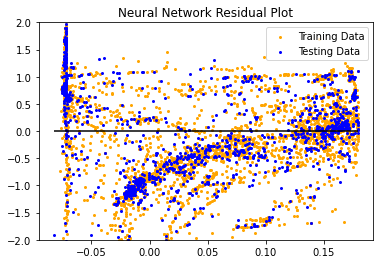

In [47]:
# Plot Residuals
import matplotlib.pyplot as plt

plt.title('Neural Network Residual Plot')
plt.scatter(predictions1, predictions1 - y_train_scaled, c= "orange",label="Training Data", s=4)
plt.scatter(predictions, predictions - y_test_scaled, c= "blue",label="Testing Data",s=4)
plt.ylim(-2,2)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.legend()

plt.savefig('neuralnetworkresidual.png')
plt.show()